In [1]:
#notebook for testing the search of song in a wav file

## Load everything
%matplotlib inline
import pdb
import sys
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import logging
matplotlib.style.use('ggplot')

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)

matplotlib.style.use('ggplot')

# Set up Computer and paths
comp_name=socket.gethostname()
print 'Computer: ' + comp_name

if 'passaro' in comp_name or 'niao' in comp_name:
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')
    raw_data_folder = os.path.join(experiment_folder, 'raw_data')
    ss_data_folder = os.path.join(experiment_folder, 'ss_data')
    
#grab soundtools
from swissknife.streamtools.streams import WavData, Chunk
from swissknife.streamtools import findsong

    
#file structure
bird_id = 'z035'
sess = '2017-04-18'
rec = '06-00-01-12'
bout = None

#load the bout and the whole sound file for searching
raw_file_folder = os.path.join(raw_data_folder, bird_id, str(sess).zfill(3))
raw_file_name = rec + '.wav'
raw_file_path = os.path.join(raw_file_folder, raw_file_name)

bout_file_name = rec + '_autobouts.wav'
bout_file_path = os.path.join(raw_file_folder, bout_file_name)

#the whole sound
all_sound = WavData(raw_file_path)

#the bout
if bout is not None:
    raw_file_folder = os.path.join(raw_file_folder, 'bouts')
    raw_file_name = rec + '_' + str(run).zfill(2) + '_song_' + bout + '.wav'

raw_file_path = os.path.join(raw_file_folder, raw_file_name)
# bout_sound = WavData(raw_file_path)
# bout_sound.close()

Computer: passaro


2017-06-21 10:41:28,374 streamtools.streams INFO     wavdata


In [2]:
raw_file_path = '/mnt/cube/earneodo/bci_zf/raw_data/s001/2017-03-26/06-00-02-20.wav'
bout_file_path = '/mnt/cube/earneodo/bci_zf/raw_data/s001/2017-03-26/06-00-02-20_tuvieja.wav'
#bout_sound = WavData(raw_file_path)

In [3]:
def rms(x):
    return np.std(x, axis=0)

def mad(x):
    med = np.median(x)
    dev = np.abs(x - np.median(x))
    return np.median(dev)



def band_pass_filter(chunk, hp_b, hp_a, lp_b, lp_a):    
    chunk_hi = sg.filtfilt(hp_b, hp_a, chunk)
    chunk_filt = sg.filtfilt(lp_b, lp_a, chunk_hi)
    return chunk_filt

#decorator for getting the rms after applying a filter to a segment
def rms_after_filter(filter_func):
    def out_of_filtered(*args, **kwargs):
        #print "Arguments were: %s, %s" % (args, kwargs)
        #plt.plot(np.transpose(filter_func(*args, **kwargs)))
        return np.linalg.norm(filter_func(*args, **kwargs))
    return out_of_filtered

@rms_after_filter
def rms_band_pass_filter(chunk, hp_b, hp_a, lp_b, lp_a):
    #plt.plot(np.transpose(chunk))
    chunk_hi = sg.filtfilt(hp_b, hp_a, chunk)
    chunk_filt = sg.filtfilt(lp_b, lp_a, chunk_hi)
    return chunk_filt

@rms_after_filter
def rms_identity(chunk):
    return(chunk)

In [8]:
#Parameters of the search
bit_size = 50 # ms; size of sound bits
refractory = 5 # bits; refractory period in bits
bits_bout = 2 # bits; how many bouts together is considered a bout
threshold = 20 # threshold in mads (median deviation of the median)

#The band where we expect most of the energy of zf song to be in
filt_lo = 10000 #Hz
filt_hi = 300 #Hz

from itertools import groupby
from operator import itemgetter
import wave
import struct

def get_bouts(all_sound, bit_size=70, refractory=5, bits_bout=4, threshold=20, 
              filt_lo=1000, filt_hi=500):
    
    s_f = all_sound.s_f
    
    #make the filter
    hp_b, hp_a = sg.butter(4, filt_hi/(s_f/2.), btype='high')
    lp_b, lp_a = sg.butter(4, filt_lo/(s_f/2.), btype='low')

    bit_size_sample = np.int(bit_size*all_sound.s_f*0.001)
    all_starts = np.arange(0, all_sound.n_samples - bit_size_sample, bit_size_sample)

    #get all the rms
    print('getting rms')
    all_rms = all_sound.apply_repeated(all_starts, bit_size_sample, rms_band_pass_filter, hp_b, hp_a, lp_b, lp_a)

    thresh_rms = np.median(all_rms) + threshold * mad(all_rms)
    
    supra_bits = np.where(all_rms > thresh_rms)[0]
    plt.plot(np.arange(supra_bits.size), supra_bits, '*')
    
    group_bound = np.array([0, 0], dtype=np.int32)

    for k, g in groupby(enumerate(supra_bits), lambda (i, x): i-x):
        group = map(itemgetter(1), g)
        if len(group) >= bits_bout:
            group_bound = np.vstack((group_bound, np.array([group[0], group[-1]])) )
            #print group

    if group_bound.size > 2:
        found_bouts = True
        group_bound = np.delete(group_bound, 0, axis=0)
        # segments has to be in samples 
        segments = np.array([all_starts[group_bound[:,0]], all_starts[group_bound[:,1]]])
        assert(np.all(np.diff(segments, axis=0)[0]>0))

    else:
        segments = None

    return segments

def write_segments(segments, all_sound, bout_file_path, bit_size, more=2):
    bit_size_sample = np.int(bit_size*all_sound.s_f*0.001)
    n_seg = segments.shape[1]
    chopped_segments = np.zeros_like(found_segments.T)
    #open the file
    print(bout_file_path)
    bouts_out = wave.open(bout_file_path, 'w')
    
    try:
        #logger.info(bout_file_path)
        bouts_out.setparams((all_sound.n_chans, 2, all_sound.s_f, 0, 'NONE', 'not compressed'))
        for i_seg, seg in enumerate(segments.T):
            seg = seg + np.array([-more, more])* bit_size_sample
            start = seg[0] if seg[0] > 0 else 0
            end = seg[1] if seg[1] < all_sound.n_samples else all_sound.n_samples
            chopped_segments[i_seg] = np.array([start, end])
            #print start, end
            sg_chunk = Chunk(all_sound, segment = [start, end])
            # save the chunk to a data file
            #filter for debugging
            #sg_chunk.apply_filter(band_pass_filter, hp_b, hp_a, lp_b, lp_a)
            data_out = np.array(sg_chunk.data, dtype=np.int16)[0]
            packed_data = struct.pack('<' + str((end - start)) + 'h', *data_out)
            bouts_out.writeframes(data_out)
        bouts_out.close()
        
    except Exception as inst:
        bouts_out.close()
        raise(inst)
    

            
found_segments = findsong.get_bouts(all_sound, bit_size=bit_size, refractory=refractory, bits_bout=bits_bout,
                       threshold=threshold, filt_lo=filt_lo, filt_hi=filt_hi)

chopped_segments = findsong.write_segments(found_segments, all_sound, bout_file_path, bit_size, more=2)


2017-06-21 10:44:17,434 findsong     DEBUG    Saving bouts in /mnt/cube/earneodo/bci_zf/raw_data/s001/2017-03-26/06-00-02-20_tuvieja.wav


In [12]:
import imp
imp.reload(findsong)

<module 'swissknife.streamtools.findsong' from '/mnt/cube/earneodo/repos/swissknife/swissknife/streamtools/findsong.py'>

In [25]:
chopped_segments = np.zeros_like(found_segments.T)
chopped_segments[:] = np.nan

In [27]:
chopped_segments[0] = np.array([3, 4])
chopped_segments.dtype

dtype('int64')

In [ ]:
for seg in segments.T:
    seg = seg + np.array([-more, more])* bit_size_sample

    start = seg[0] if seg[0] > 0 else 0
    end = seg[1] if seg[1] < all_sound.n_samples else all_sound.n_samples

In [13]:
found_seg = findsong.get_all_bouts(raw_file_path, bit_size=bit_size, refractory=refractory, bits_bout=bits_bout,
                       threshold=threshold, filt_lo=filt_lo, filt_hi=filt_hi)

2017-06-21 10:51:03,199 findsong     INFO     Will get bouts for file /mnt/cube/earneodo/bci_zf/raw_data/s001/2017-03-26/06-00-02-20.wav
2017-06-21 10:51:03,200 findsong     DEBUG    Auto assigned bout_file_name
2017-06-21 10:51:03,218 streamtools.streams INFO     wavdata
2017-06-21 10:51:24,408 findsong     INFO     Writing segments to /mnt/cube/earneodo/bci_zf/raw_data/s001/2017-03-26/06-00-02-20_auto.wav
2017-06-21 10:51:24,409 findsong     DEBUG    Saving bouts in /mnt/cube/earneodo/bci_zf/raw_data/s001/2017-03-26/06-00-02-20_auto.wav
2017-06-21 10:51:27,974 findsong     DEBUG    Saving stamps to /mnt/cube/earneodo/bci_zf/raw_data/s001/2017-03-26/06-00-02-20_auto.stamps.npy
2017-06-21 10:51:27,994 findsong     DEBUG    Closing raw file


2017-06-20 18:20:23,738 streamtools.streams INFO     wavdata


getting rms


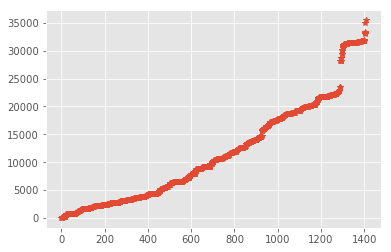

In [15]:
all_sound = WavData(raw_file_path)
found_segments = get_bouts(all_sound, bit_size=bit_size, refractory=refractory, bits_bout=bits_bout,
                      threshold=threshold, filt_lo=filt_lo, filt_hi=filt_hi)